# Analysis of HPL

This notebook performs data analysis of the csv files created by running the HPL benchmark

In [27]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

In [28]:
# Store the results in a dictionary of lists
results = {
    "Cloud_HPL":[],
    "SCARF_HPL":[]
}

# Parse data from csvs from each of the different results
for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            results[dataName].append(thisRow)
            

# Print a taste of the data, for a quick check that it worked
for dataName in results:
    print(dataName)
    print("1st datapoints")
    print(results[dataName][0])
    print("Headers")
    print(results[dataName][0].keys())
    print()
        

Cloud_HPL
1st datapoints
{'File Name': '20170327_035001.out', 'Q': '2', 'Time': '1788.85', 'P': '2', 'N': '44640', 'T/V': 'WR11R2C4', 'NB': '180', 'Gflops': '3.315e+01', 'Number of Hosts': '1'}
Headers
dict_keys(['File Name', 'Q', 'Time', 'P', 'N', 'T/V', 'NB', 'Gflops', 'Number of Hosts'])

SCARF_HPL
1st datapoints
{'Hosts Used': '4*cn528.scarf.rl.ac.uk', 'T/V': 'WR11R2C4', 'NB': '180', 'Start Time': 'Thu Mar 23 11:31:26 2017', 'Host Groups': 'scarf15', 'Exclusive': '1', 'File Name': '482673.out', 'Turnaround time (sec.)': '481', 'Run time (sec.)': '489', 'Max Processes': '12', 'Q': '2', 'CPU time (sec.)': '1898.16', 'Number of Hosts': '1', 'Protocols Seen': 'SHM', 'Average Memory (MB)': '13533.07', 'N': '44640', 'Total Requested Memory (MB)': '-', 'Delta Memory (MB)': '-', 'Max Threads': '14', 'Gflops': '1.325e+02', 'Max Swap (MB)': '16549', 'Max Memory (MB)': '15576.47', 'P': '2', 'Time': '447.67'}
Headers
dict_keys(['Hosts Used', 'T/V', 'NB', 'Start Time', 'Host Groups', 'Exclusive

In [29]:
import datetime

# Do cloud dates:
for result in results["Cloud_HPL"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF uppercase and map 'X-X' -> 'X'
for result in results["SCARF_HPL"]:
    result["Host Groups"] = result["Host Groups"].split("-")[0].upper()
    

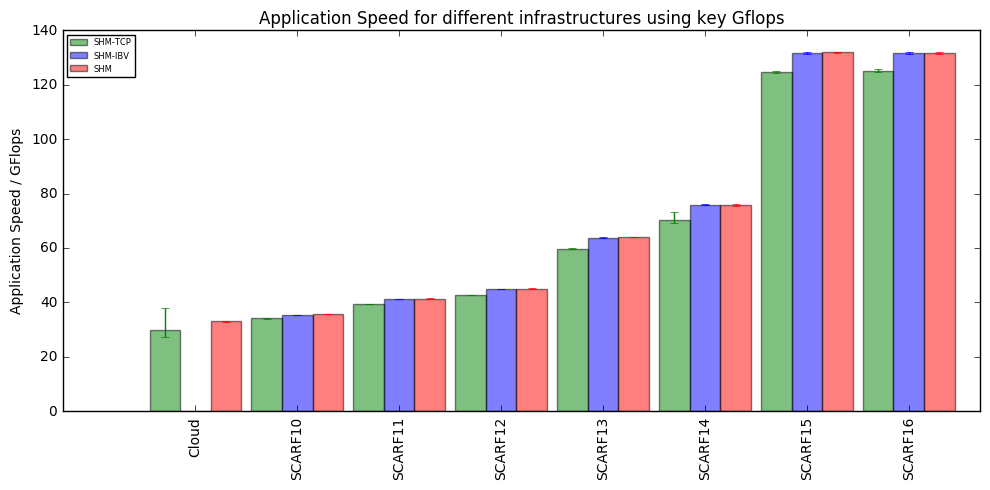

In [26]:
def plotGflops(BW_KEY="Gflops"):
    
    xValues = []
    clrs = {"SHM": "r", "SHM-TCP":"g", "SHM-IBV":"b"}
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfData, label):
        listOfData = [float(val) for val in listOfData]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfData) / len(listOfData)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfData) - avg)
        yBottomError[label].append(avg - min(listOfData))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues.append("Cloud")
    
    
    # Add the SCARF split into host group and number of hosts
    for hostgroup in sorted(set(row["Host Groups"] for row in results["SCARF_HPL"])):
        xValues += [hostgroup]
        for prot in sorted(set(row["Protocols Seen"] for row in results["SCARF_HPL"])):
            addBarData([row[BW_KEY] for row in results["SCARF_HPL"] 
                        if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]], prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.3
    
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.5, label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yTopError[label], yBottomError[label]], linestyle=" ", 
                     color=clrs[label])
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Application Speed / GFlops")
    # plt.yscale("log")
    plt.title('Application Speed for different infrastructures using key {}'.format(BW_KEY))

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()
    


plotGflops()